## Powerpoint Automation with python-pptx python package

Developed by Catherine Bui

Functionality of program:

    - add Table and Graph to powerpoint 
    
    - demonstrate the usage of python-pptx and OOP to automate data visualization and tables for presentation
    
Content:
1. Define sample table
2. Define sample graph
3. Create PresentationReport class with methods to add Table and Graph
4. Execute class and functions to create a powerpoint report slide to present on the sample data

In [40]:
from pptx import Presentation
from pptx.dml.color import ColorFormat, RGBColor
from pptx.util import Inches, Pt, Cm
from pptx.enum.text import MSO_AUTO_SIZE
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import io
import enum

In [4]:
## sample table - data for simulation purposes

df_patient_enrollment = pd.DataFrame(columns = ['Quarter', 'Number of Patients'])
df_patient_enrollment['Quarter'] = pd.Series(['2023-Q1', '2023-Q2', '2023-Q3', '2023-Q4'])
df_patient_enrollment['Number of Patients'] = pd.Series([10, 20, 30, 40])
df_patient_enrollment

,Quarter,Number of Patients
0,2023-Q1,10
1,2023-Q2,20
2,2023-Q3,30
3,2023-Q4,40


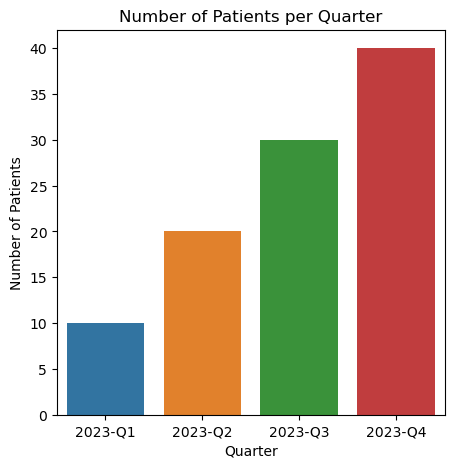

In [18]:
## sample graph of sample table above

## create scatterplot graph
fig = plt.figure(figsize = (5,5))
plt.xlabel('Number of Patients')
plt.ylabel('Quarters')
plt.title('Number of Patients per Quarter')
sns.barplot(x = 'Quarter', y = 'Number of Patients', data = df_patient_enrollment)
plt.show()

## save static scatterplot into image stream
image_stream = io.BytesIO()
fig.savefig(image_stream)

In [32]:
class PresentationReport:
    def __init__(self, title):
        self.title = title
        self.prs = Presentation()
        self.graph_positions = {'top': Inches(0.9),
                                'left': Cm(1),
                                'width': Inches(9),
                                'height': Inches(4.3)
                               }
    def set_graph_positions(self, top = None, left = None, width = None, height = None):
        if top:
            self.graph_positions['top'] = top
        if left:
            self.graph_positions['left'] = left
        if width:
            self.graph_positions['width'] = width
        if height:
            self.graph_positions['height'] = height
            
    def getPresentation(self):
        return self.prs
    def addTitleSlide(self, title_text, subtitle_text = ''):
        prs = self.prs
        title_slide_layout = prs.slide_layouts[0]
        slide = prs.slides.add_slide(title_slide_layout)
        title = slide.shapes.title
        subtitle = slide.placeholders[1]

        title.text = title_text
        subtitle.text = subtitle_text
        print(title_text)
        return self
    def addTitleText(self, slide, title_text,  font_size = Pt(30)):
        if title_text == '':
            sp = slide.placeholders[0]._sp
            sp.getparent().remove(sp)
        else:
            title = slide.shapes.title
            title.text = title_text
            title.text_frame.paragraphs[0].font.size = font_size
            title.top = Cm(1)
            title.left = Cm(3)
            title.width = Inches(8)
    def addGraphSlide(self, image_stream, title_text = '',  font_size = None):
        prs = self.prs
        titleonly_slide = prs.slide_layouts[5]
        slide = prs.slides.add_slide(titleonly_slide)

        slide.shapes.add_picture(image_stream, top = self.graph_positions.get('top'), 
                                            left = self.graph_positions.get('left'), 
                                             width = self.graph_positions.get('width'), 
                                             height= self.graph_positions.get('height'))

        self.addTitleText(slide, title_text, font_size = font_size)

        return self
    def addTableSlide(self, dataframe, title_text = '',  
                      title_font_size = None,
                      cell_font_size = Pt(7),
                      columns_limit = 21, 
                      show_all_columns = False, 
                      graph_positions = {'top': Cm(1),
                                         'left': Cm(0.5)},
                      width = Inches(9.3),
                      height = Inches(2),
                      index_column_width = Cm(2),
                    columns_color = None,
                     rows_color = None,
                     table_style = None):
        prs = self.prs
        dataframe = dataframe.copy()
        index_columns = dataframe.index
        dataframe = dataframe.iloc[:, -columns_limit:]
        dataframe = dataframe.reset_index()
        num_rows, num_cols = dataframe.shape
        titleonly_slide = prs.slide_layouts[5]
        slide = prs.slides.add_slide(titleonly_slide)
        shapes_dict = dict((s.name, s) for s in slide.shapes)
        
        self.addTitleText(slide, title_text, font_size = title_font_size)        
        def addTable(slide):
            ## a slide is max 10 inches across and 6 inches height
            x,y,cx,cy = graph_positions.get('left'), graph_positions.get('top'), width, height
            table_shape = slide.shapes.add_table(num_rows+1, num_cols, x,y,cx,cy)
            table = table_shape.table
            table.top = graph_positions.get('top')
            table.left = graph_positions.get('left')
            def pushColumnstoRow0(dataframe):
                dataframe.loc[-1] = dataframe.columns
                dataframe.index = dataframe.index + 1
                dataframe.sort_index(inplace = True)
                dataframe.columns = [col for col in range(0, dataframe.shape[1])]
                return dataframe

            new_dataframe = pushColumnstoRow0(dataframe)
            xydf = new_dataframe.stack().rename_axis(['y', 'x']).reset_index(name = 'val')


            def addCell(row):
                if columns_color:
                    if row['y'] % 2 == 0:
                        table.cell(row['y'], row['x']).fill.solid()
                        table.cell(row['y'], row['x']).fill.fore_color.rgb = RGBColor(255, 255, 255)
                    if row['y'] % 2 == 1:
                        table.cell(row['y'], row['x']).fill.solid()
                        table.cell(row['y'], row['x']).fill.fore_color.rgb = RGBColor(240, 240, 240)  
                    if row['y'] == 0:
                        table.cell(row['y'], row['x']).fill.solid()
                        table.cell(row['y'], row['x']).fill.fore_color.rgb = RGBColor(227, 228, 232)
                table.cell(row['y'], row['x']).text = str(row['val'])
                table.cell(row['y'], row['x']).width = Inches(0.3)
                table.cell(row['y'], row['x']).height = Cm(1)
                table.cell(row['y'], row['x']).text_frame.paragraphs[0].font.size = cell_font_size
            xydf.apply(lambda h: addCell(h), axis = 1)
            pptx_table_cols = table.columns
            pptx_table_cols[0].width = index_column_width
        addTable(slide)
        return self
    def save(self, file_name_location):
        print('pptx saved')
        try:
            self.prs.save(file_name_location)
        except:
            self.prs.save(file_name_location.replace('.pptx', '') + ' ' + str(datetime.datetime.now().strftime("%d%b%Y")) + '.pptx')

In [39]:
title = 'Number of Patients Over Quarters'        
## initialize presentation
prs = PresentationReport(title)

## add title slide to presentation 
prs.addTitleSlide(title, subtitle_text = "Data Extracted: {0}".format(datetime.datetime.now().strftime('%b %d, %Y')))

## add table to Table Slide
prs.addTableSlide(df_patient_enrollment.set_index('Quarter'), title_text = 'Number of Patients Over Quarters', 
                  title_font_size = Pt(32), 
                  cell_font_size = Pt(12),
                  graph_positions = {'top': Inches(2),'left': Inches(2)},
                                    index_column_width = Cm(5),
                 columns_color=  RGBColor(235, 237, 245))

## adjust graph positions for image
prs.set_graph_positions(top = Inches(0.9), left = Cm(4), width = Inches(7), height = Inches(6))

## add sample image stream to Graph Slide
prs.addGraphSlide(image_stream, title_text = "Bar Plot", font_size = Pt(32))

## save presentation
prs.save(title + '.pptx')

Number of Patients Over Quarters
pptx saved
